In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import joblib

import src.utils as utils

/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_76911/898839591.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data loading

In [3]:
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
ds.print_data()
print("Loaded.")

#X_train = np.concatenate((ds.X_train[:,0:12],ds.X_valid[:,0:12])).copy()
#Y_train = np.concatenate((ds.y_train,ds.y_valid)).copy()/10

#T_train = 1000/(np.concatenate((ds.T_train, ds.T_valid)).copy())
#P_train = np.concatenate((ds.P_train, ds.P_valid)).copy()

#X_train = np.concatenate((T_train.reshape(-1,1), P_train.reshape(-1,1), X_train), axis=1).copy()

X_train = np.concatenate((1000/ds.T_train, ds.P_train, ds.X_train[:,0:12]), axis=1).copy()
X_valid = np.concatenate((1000/ds.T_valid, ds.P_valid, ds.X_valid[:,0:12]), axis=1).copy()
X_test  = np.concatenate((1000/ds.T_test,  ds.P_test,  ds.X_test[:,0:12]),  axis=1).copy()

Y_train = ds.y_train.copy()/10
Y_valid = ds.y_valid.copy()/10
Y_test  = ds.y_test.copy()/10

# joint valid and train
X_train = np.concatenate((X_train,X_valid))
Y_train = np.concatenate((Y_train,Y_valid))

X_scaler = StandardScaler()
X_train_sc = X_scaler.fit_transform(X_train)
#X_valid_sc = X_scaler.transform(X_valid)
X_test_sc = X_scaler.transform(X_test)

# dataset for GP
D = gpx.Dataset(X=X_train_sc, y=Y_train)


Loading the viscosity datasets...
################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 2912
Number of unique compositions in training (viscosity): 2258
Dataset separations are 0.78 in train, 0.11 in valid, 0.11 in test

This is for checking the shape consistency of the dataset:

Visco train shape
(11767, 155)
(11767, 1)
(11767, 1)
Loaded.


# Sparse regression GP. Training. (skip if a model is trained).

In [4]:
# kernel for prior
# initiate the scales with different values for the different input dims
# Best results for now with kernels RBF + lineas, different scales for each inputs, all active.
# no kernel for temperature
#kernel_T = gpx.kernels.Matern32(active_dims=[0]) + gpx.kernels.Constant(active_dims=[0])
#dims_XP = [i for i in range(1,X_train_sc.shape[1])]
init_scales = np.ones(X_train_sc.shape[1])
kernel = gpx.kernels.Matern32(lengthscale=init_scales) + gpx.kernels.Polynomial(active_dims=[0])

meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

#now the likelihood and posterior
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

# Get inducing variables
# for that we use kmeans
rng = np.random.default_rng(1234)
from scipy.cluster.vq import kmeans

n_inducing = 748
inducing_variable, _ = kmeans(X_train_sc, n_inducing)
#inducing_variable = rng.choice(X_train_sc, size=n_inducing, replace=False)

# declaration for sparse GP
q = gpx.variational_families.CollapsedVariationalGaussian(
    posterior=posterior, inducing_inputs=inducing_variable
)

# objective
elbo = gpx.objectives.CollapsedELBO(negative=True)
elbo = jit(elbo)



  0%|          | 0/1000 [00:00<?, ?it/s]

['./models/GP_model_kernel5_trainvalidjoined.gz']

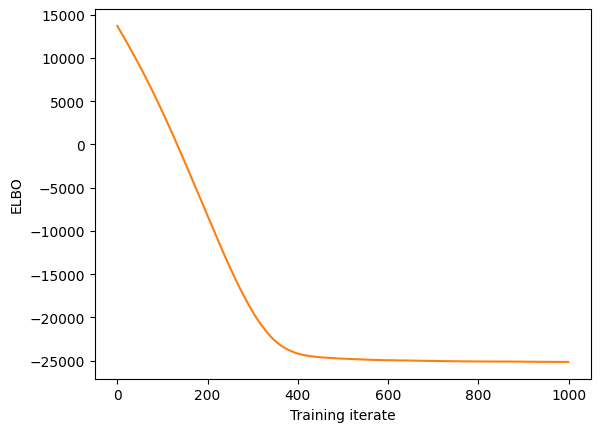

In [5]:
import optax as ox
key = jr.PRNGKey(123)

# training
opt_posterior, history = gpx.fit(
    model=q,
    objective=elbo,
    train_data=D,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters=1000,
    key=key,
)

fig, ax = plt.subplots()
ax.plot(history, color="C1")
ax.set(xlabel="Training iterate", ylabel="ELBO")

joblib.dump(opt_posterior, "./models/GP_model_kernel5_trainvalidjoined.gz")


# Loading trained model

In [8]:
#opt_posterior = joblib.load("./models/GP_model_kernel4.gz")

In [6]:
valid_latent_dist = opt_posterior(X_valid_sc, train_data=D)
valid_predictive_dist = opt_posterior.posterior.likelihood(valid_latent_dist)
#inducing_points = opt_posterior.inducing_inputs
#samples = latent_dist.sample(seed=key, sample_shape=(100,))

valid_predictive_mean = valid_predictive_dist.mean()
valid_predictive_std = valid_predictive_dist.stddev()

NameError: name 'X_valid_sc' is not defined

In [7]:
#train_latent_dist = opt_posterior(X_train_sc, train_data=D)
#train_predictive_dist = opt_posterior.posterior.likelihood(train_latent_dist)

#train_predictive_mean = train_predictive_dist.mean()
#train_predictive_std = train_predictive_dist.stddev()

#X_test_sc = ds.TPX_test_scaled[:,0:24].copy()

test_latent_dist = opt_posterior(X_test_sc, train_data=D)
test_predictive_dist = opt_posterior.posterior.likelihood(test_latent_dist)
#inducing_points = opt_posterior.inducing_inputs
#samples = latent_dist.sample(seed=key, sample_shape=(100,))

test_predictive_mean = test_predictive_dist.mean()
test_predictive_std = test_predictive_dist.stddev()

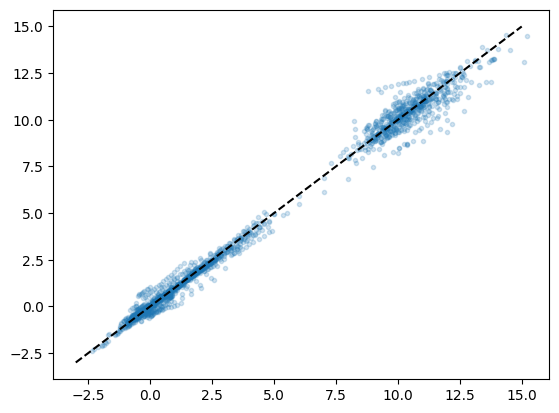

In [8]:
#plt.plot(Y_train*10, train_predictive_mean*10,".", alpha=0.2)
plt.plot(Y_test*10, test_predictive_mean*10,".", alpha=0.2)
plt.plot([-3,15],[-3,15],"k--")

In [9]:
from sklearn.metrics import mean_squared_error
#mean_squared_error(Y_valid*10, valid_predictive_mean*10)
mean_squared_error(Y_test*10, test_predictive_mean*10)

0.20798792846161002

In [20]:
mean_squared_error(Y_train*10, train_predictive_mean*10)

0.08502559154322659

0.22907964634160774

In [41]:
di_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="NAK75_12_0")|
                     (ds.dataset_lp.Name_publi=="Ab"),:].reset_index()


T_interest = np.arange(900,10000.,500.).reshape(-1,1)
P_interest = np.zeros(len(T_interest)).reshape(-1,1)

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values
# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

def scale_for_gp(xi, T_interest, P_interest):
    # transformation
    X_input = np.concatenate((1000/T_interest.reshape(-1,1).copy(),
                              P_interest.reshape(-1,1).copy(),xi[:,0:12].copy()),axis=1)
    X_input_sc = X_scaler.transform(X_input)
    return X_input_sc

X_abt_sc = scale_for_gp(xi, T_interest, P_interest)

pr_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Pr"),:].reset_index()
# add descriptors
xi_ = utils.descriptors(pr_.loc[:, utils.list_oxides()]/100).values
# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]
X_pr_sc = scale_for_gp(xi, T_interest, P_interest)

data_albite = pd.read_excel("./data/albite_test.xlsx")
data_peridotite = pd.read_excel("./data/albite_test.xlsx", sheet_name="peridotite")

def VFT(x,B,C):
    return -4.5 + B/(x-C)

from scipy.optimize import curve_fit
pinit = [5000, 500]
popt, pcov = curve_fit(VFT, data_albite["T"], data_albite.Y,p0=pinit)
popt_peridotite, pcov_peridotite = curve_fit(VFT, data_peridotite["T"], data_peridotite.Y,p0=pinit)


In [42]:
latent_dist = opt_posterior(X_abt_sc, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)
#inducing_points = opt_posterior.inducing_inputs
#samples = latent_dist.sample(seed=key, sample_shape=(100,))

abt_predictive_mean, abt_predictive_std = predictive_dist.mean(), predictive_dist.stddev()

latent_dist = opt_posterior(X_pr_sc, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)
pr_predictive_mean, pr_predictive_std = predictive_dist.mean(), predictive_dist.stddev()

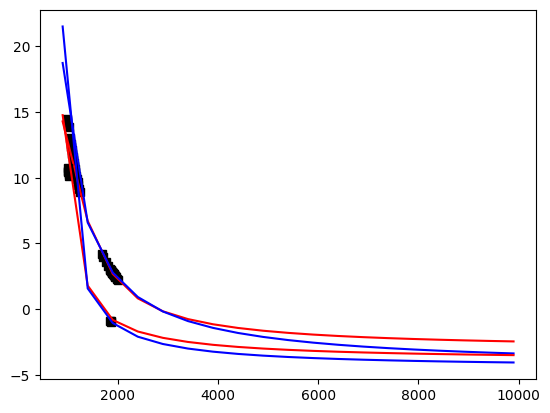

In [43]:
plt.plot(data_albite["T"], data_albite["Y"],"ks")
plt.plot(T_interest, abt_predictive_mean*10,"r-")
#plt.plot(T_interest, abt_predictive_mean*10-1.96*abt_predictive_std*10,"r--")
#plt.plot(T_interest, abt_predictive_mean*10+1.96*abt_predictive_std*10,"r--")
plt.plot(T_interest, VFT(T_interest, *popt),"b-")

plt.plot(data_peridotite["T"], data_peridotite["Y"],"ks")
plt.plot(T_interest, pr_predictive_mean*10,"r-")
#plt.plot(T_interest, pr_predictive_mean*10-1.96*pr_predictive_std*10,"r--")
#plt.plot(T_interest, pr_predictive_mean*10+1.96*pr_predictive_std*10,"r--")
plt.plot(T_interest, VFT(T_interest, *popt_peridotite),"b-")



# Pressure effect

In [13]:
###
# Peridotite
###
dataset_peridotite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="peridotite",:].reset_index()
# add descriptors
xi_ = utils.descriptors(dataset_peridotite.loc[:, utils.list_oxides()]/100).values

ptxi_peridotite = scale_for_gp(xi_, 
                               dataset_peridotite["T"].values, 
                               dataset_peridotite["P"].values)

latent_dist = opt_posterior(ptxi_peridotite, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

inducing_points = opt_posterior.inducing_inputs

peridotite_predictive_mean = predictive_dist.mean()
peridotite_predictive_std = predictive_dist.stddev()


In [14]:

###
# CaSiO3
###
dataset_casio3 = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="casio3",:].reset_index()
# add descriptors
xi_ = utils.descriptors(dataset_casio3.loc[:, utils.list_oxides()]/100).values

# transformation
ptxi_casio3 = scale_for_gp(xi_, 
                               dataset_casio3["T"].values, 
                               dataset_casio3["P"].values)

latent_dist = opt_posterior(ptxi_casio3, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

inducing_points = opt_posterior.inducing_inputs

casio3_predictive_mean = predictive_dist.mean()
casio3_predictive_std = predictive_dist.stddev()

###
# Albite
###
dataset_albite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()
# add descriptors
xi_ = utils.descriptors(dataset_albite.loc[:, utils.list_oxides()]/100).values

# transformation
ptxi_albite = scale_for_gp(xi_, 
                               dataset_albite["T"].values, 
                               dataset_albite["P"].values)

latent_dist = opt_posterior(ptxi_albite, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

inducing_points = opt_posterior.inducing_inputs

albite_predictive_mean = predictive_dist.mean()
albite_predictive_std = predictive_dist.stddev()

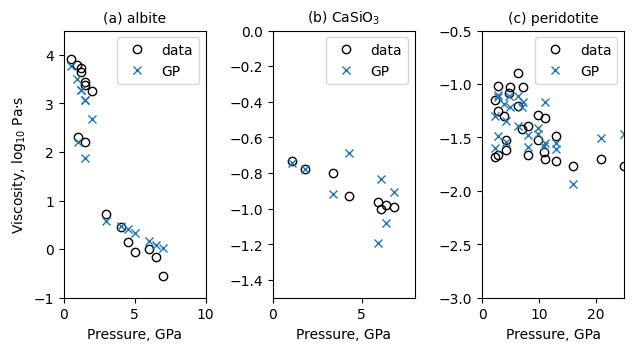

In [15]:
plt.figure(figsize=(6.44,6.44))
plt.subplot(2,3,1)
plt.title("(a) albite", fontsize=10)
plt.plot(dataset_albite.loc[:,"P"],dataset_albite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_albite.loc[:,"P"],
         albite_predictive_mean*10,"x", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
plt.ylim(-1,4.5)
plt.xlim(0,10)
plt.legend()

plt.subplot(2,3,2)
plt.title("(b) CaSiO$_3$", fontsize=10)
plt.plot(dataset_casio3.loc[:,"P"],dataset_casio3.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_casio3.loc[:,"P"],
         casio3_predictive_mean*10,"x", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-1.5,0)
plt.xlim(0,8)
plt.legend()

plt.subplot(2,3,3)
plt.title("(c) peridotite", fontsize=10)
plt.plot(dataset_peridotite.loc[:,"P"],dataset_peridotite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_peridotite.loc[:,"P"],
         peridotite_predictive_mean*10,"x", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-3.0,-0.5)
plt.xlim(0,25)
plt.legend()

plt.tight_layout()

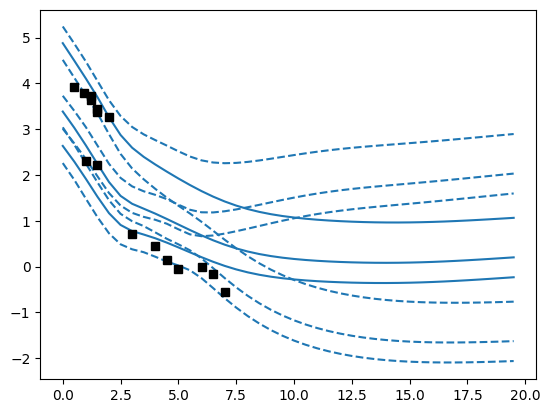

In [17]:
P_interest = np.arange(0,20.,0.5)

# add descriptors
xi_ = utils.descriptors(dataset_albite.loc[:, utils.list_oxides()]/100).values

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(P_interest),xi_.shape[1]))*xi_[0,:]

# Albite dataset
for i in [1873, 1673, 2000]:
    T_interest = i*np.ones(len(P_interest))

    # transformation
    ptxi_scaled = scale_for_gp(xi, 
                                   T_interest.reshape(-1,1), 
                                   P_interest.reshape(-1,1))
    latent_dist = opt_posterior(ptxi_scaled, train_data=D)
    predictive_dist = opt_posterior.posterior.likelihood(latent_dist)
    inducing_points = opt_posterior.inducing_inputs

    plt.plot(P_interest, predictive_dist.mean()*12,color="C0",linestyle="-")
    plt.plot(P_interest, predictive_dist.mean()*12+predictive_dist.stddev()*12,color="C0",linestyle="--")
    plt.plot(P_interest, predictive_dist.mean()*12-predictive_dist.stddev()*12,color="C0",linestyle="--")

plt.plot(dataset_albite["P"], dataset_albite["viscosity"], "ks")


In [35]:
import gpytorch
import torch

train_x = torch.FloatTensor(X_train_sc)
train_y = torch.FloatTensor(Y_train)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [37]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

KeyboardInterrupt: 

In [29]:
inducing_points.shape

(743, 26)